<a href="https://colab.research.google.com/github/BradenEberhard/TimeSeries/blob/main/Time_Series_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. only use last hidden layer
2. hyper tune, lr, batch size, num layers, training window
4. add attention
5. maybe try a transformer

In [1]:
import os
import time
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import random
import datetime

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train = pd.read_csv('./drive/MyDrive/Models/Time Series/train.csv', parse_dates=[0])
test = pd.read_csv('./drive/MyDrive/Models/Time Series/test.csv', parse_dates=[0], index_col='id')

In [4]:
def get_all_items_seq(train = train, tw = 50):
  scaler = MinMaxScaler()
  new_df = train.sort_values(['date', 'store', 'item'], ascending=[True, True, True])
  new_df.sales = scaler.fit_transform(np.array(new_df.sales).reshape(-1,1))
  new_df = torch.FloatTensor([new_df[new_df.date == x].sales for x in np.unique(new_df.date)])
  inout_seq = []
  L = len(new_df)
  for i in tqdm(range(L - tw)):
    train_seq = new_df[i:i+tw,:]
    train_label = new_df[i+tw:i+tw+1,:]
    inout_seq.append((train_seq, train_label))
  return inout_seq, scaler

In [5]:
class inputs_dataset(Dataset):

    def __init__(self, tensor):

        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx]

    def check(self, idx):
      return self.tensor[idx]




In [17]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1, batch_size = 1, tw = 50):
    super().__init__()
    self.hidden_layer_size = hidden_layer_size
    self.batch_size = batch_size
    self.tw = tw
    self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first = True)

    self.linear = nn.Linear(hidden_layer_size, output_size)

    self.hidden_cell = (torch.zeros(num_layers,batch_size,self.hidden_layer_size).cuda(),
                        torch.zeros(num_layers,batch_size,self.hidden_layer_size).cuda())
    
  def forward(self, input_seq):
    lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
    predictions = lstm_out.view(self.tw, -1)
    attention_tens = torch.mm(predictions[:-1],predictions[-1].view(-1,1))
    out_to_linear = torch.mm(torch.transpose(predictions[:-1], 0, 1), attention_tens)
    return self.linear(out_to_linear.view(-1))

In [18]:
PATH = './drive/MyDrive/Models/Time Series/LSTM.all_stores_and_items.50_window.1_layers.v0'
LOAD_MODEL = False
SAVE_MODEL = True
TRAIN_WINDOW = 365
BATCH_SIZE = 1
NUM_LAYERS = 1

sequence, scaler = get_all_items_seq(tw=TRAIN_WINDOW)
my_data = inputs_dataset(sequence)
my_loader = DataLoader(my_data, batch_size=BATCH_SIZE, shuffle=True)

model = LSTM(input_size=500, hidden_layer_size=500, output_size=500, num_layers=NUM_LAYERS, batch_size=BATCH_SIZE, tw=TRAIN_WINDOW).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
epochs = 100

if LOAD_MODEL:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  losses = checkpoint['losses']
else:
  epoch = 0
  losses = []
for i in tqdm(range(epochs)):
  for seq, labels in my_loader:

    seq = seq.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(NUM_LAYERS,BATCH_SIZE,model.hidden_layer_size).cuda(),
                         torch.zeros(NUM_LAYERS,BATCH_SIZE,model.hidden_layer_size).cuda())

    y_pred = model(seq)
    single_loss = criterion(y_pred, labels)
    single_loss.backward()
    losses.append(single_loss.item())
    optimizer.step()

  if (i%10 == 0):
    print('losses: ' + str(losses[-1]) + ' epoch: ' + str(epoch + i))
    torch.save({
        'epoch': epoch + i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        }, PATH)





100%|██████████| 1461/1461 [00:00<00:00, 125661.40it/s]




  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 500])) that is different to the input size (torch.Size([500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


losses: 0.0032009186688810587 epoch: 0






  1%|          | 1/100 [00:22<37:53, 22.97s/it]



  2%|▏         | 2/100 [00:45<37:08, 22.73s/it]



  3%|▎         | 3/100 [01:07<36:35, 22.63s/it]



  4%|▍         | 4/100 [01:30<36:07, 22.58s/it]



  5%|▌         | 5/100 [01:52<35:42, 22.55s/it]



  6%|▌         | 6/100 [02:14<35:12, 22.48s/it]



  7%|▋         | 7/100 [02:37<34:48, 22.45s/it]



  8%|▊         | 8/100 [02:59<34:26, 22.46s/it]



  9%|▉         | 9/100 [03:22<34:07, 22.50s/it]



 10%|█         | 10/100 [03:44<33:48, 22.53s/it]



 11%|█         | 11/100 [04:07<33:25, 22.53s/it]

losses: 0.0016572800232097507 epoch: 10






 12%|█▏        | 12/100 [04:29<33:02, 22.52s/it]



 13%|█▎        | 13/100 [04:52<32:42, 22.56s/it]



 14%|█▍        | 14/100 [05:15<32:23, 22.60s/it]



 15%|█▌        | 15/100 [05:37<32:02, 22.61s/it]



 16%|█▌        | 16/100 [06:00<31:42, 22.65s/it]



 17%|█▋        | 17/100 [06:23<31:18, 22.63s/it]



 18%|█▊        | 18/100 [06:45<30:55, 22.62s/it]



 19%|█▉        | 19/100 [07:08<30:28, 22.58s/it]



 20%|██        | 20/100 [07:31<30:10, 22.64s/it]



 21%|██        | 21/100 [07:53<29:50, 22.67s/it]

losses: 0.0015733676264062524 epoch: 20






 22%|██▏       | 22/100 [08:16<29:23, 22.61s/it]



 23%|██▎       | 23/100 [08:38<28:58, 22.57s/it]



 24%|██▍       | 24/100 [09:01<28:36, 22.59s/it]



 25%|██▌       | 25/100 [09:23<28:11, 22.56s/it]



 26%|██▌       | 26/100 [09:46<27:48, 22.54s/it]



 27%|██▋       | 27/100 [10:08<27:24, 22.53s/it]



 28%|██▊       | 28/100 [10:31<27:03, 22.54s/it]



 29%|██▉       | 29/100 [10:54<26:42, 22.57s/it]



 30%|███       | 30/100 [11:16<26:18, 22.55s/it]



 31%|███       | 31/100 [11:39<25:57, 22.58s/it]

losses: 0.002226749435067177 epoch: 30






 32%|███▏      | 32/100 [12:01<25:37, 22.61s/it]



 33%|███▎      | 33/100 [12:24<25:09, 22.53s/it]



 34%|███▍      | 34/100 [12:46<24:44, 22.49s/it]



 35%|███▌      | 35/100 [13:09<24:21, 22.48s/it]



 36%|███▌      | 36/100 [13:31<23:59, 22.50s/it]



 37%|███▋      | 37/100 [13:54<23:36, 22.48s/it]



 38%|███▊      | 38/100 [14:16<23:14, 22.49s/it]



 39%|███▉      | 39/100 [14:39<22:54, 22.53s/it]



 40%|████      | 40/100 [15:01<22:32, 22.54s/it]



 41%|████      | 41/100 [15:24<22:10, 22.55s/it]

losses: 0.002388394670560956 epoch: 40






 42%|████▏     | 42/100 [15:46<21:48, 22.57s/it]



 43%|████▎     | 43/100 [16:09<21:27, 22.59s/it]



 44%|████▍     | 44/100 [16:32<21:04, 22.57s/it]



 45%|████▌     | 45/100 [16:54<20:42, 22.59s/it]



 46%|████▌     | 46/100 [17:17<20:19, 22.58s/it]



 47%|████▋     | 47/100 [17:39<19:56, 22.58s/it]



 48%|████▊     | 48/100 [18:02<19:36, 22.63s/it]



 49%|████▉     | 49/100 [18:25<19:15, 22.65s/it]



 50%|█████     | 50/100 [18:48<18:54, 22.69s/it]



 51%|█████     | 51/100 [19:10<18:31, 22.67s/it]

losses: 0.0026355211157351732 epoch: 50






 52%|█████▏    | 52/100 [19:33<18:07, 22.65s/it]



 53%|█████▎    | 53/100 [19:56<17:44, 22.65s/it]



 54%|█████▍    | 54/100 [20:18<17:23, 22.69s/it]



 55%|█████▌    | 55/100 [20:41<17:00, 22.67s/it]



 56%|█████▌    | 56/100 [21:04<16:37, 22.68s/it]



 57%|█████▋    | 57/100 [21:26<16:15, 22.68s/it]



 58%|█████▊    | 58/100 [21:49<15:48, 22.59s/it]



 59%|█████▉    | 59/100 [22:11<15:25, 22.57s/it]



 60%|██████    | 60/100 [22:34<15:03, 22.58s/it]



 61%|██████    | 61/100 [22:57<14:43, 22.66s/it]

losses: 0.001696958439424634 epoch: 60






 62%|██████▏   | 62/100 [23:19<14:21, 22.66s/it]



 63%|██████▎   | 63/100 [23:42<13:57, 22.62s/it]



 64%|██████▍   | 64/100 [24:05<13:35, 22.64s/it]



 65%|██████▌   | 65/100 [24:27<13:10, 22.59s/it]



 66%|██████▌   | 66/100 [24:50<12:48, 22.61s/it]



 67%|██████▋   | 67/100 [25:12<12:26, 22.61s/it]



 68%|██████▊   | 68/100 [25:35<12:03, 22.61s/it]



 69%|██████▉   | 69/100 [25:57<11:40, 22.60s/it]



 70%|███████   | 70/100 [26:20<11:16, 22.56s/it]



 71%|███████   | 71/100 [26:43<10:55, 22.61s/it]

losses: 0.0015723868273198605 epoch: 70






 72%|███████▏  | 72/100 [27:05<10:33, 22.64s/it]



 73%|███████▎  | 73/100 [27:28<10:11, 22.63s/it]



 74%|███████▍  | 74/100 [27:50<09:45, 22.53s/it]



 75%|███████▌  | 75/100 [28:13<09:22, 22.50s/it]



 76%|███████▌  | 76/100 [28:35<09:00, 22.53s/it]



 77%|███████▋  | 77/100 [28:58<08:38, 22.55s/it]



 78%|███████▊  | 78/100 [29:20<08:16, 22.57s/it]



 79%|███████▉  | 79/100 [29:43<07:54, 22.58s/it]



 80%|████████  | 80/100 [30:06<07:31, 22.57s/it]



 81%|████████  | 81/100 [30:28<07:09, 22.61s/it]

losses: 0.0009056153357960284 epoch: 80






 82%|████████▏ | 82/100 [30:51<06:47, 22.64s/it]



 83%|████████▎ | 83/100 [31:14<06:25, 22.68s/it]



 84%|████████▍ | 84/100 [31:36<06:01, 22.62s/it]



 85%|████████▌ | 85/100 [31:59<05:38, 22.59s/it]



 86%|████████▌ | 86/100 [32:22<05:16, 22.62s/it]



 87%|████████▋ | 87/100 [32:44<04:54, 22.64s/it]



 88%|████████▊ | 88/100 [33:07<04:30, 22.57s/it]



 89%|████████▉ | 89/100 [33:29<04:08, 22.56s/it]



 90%|█████████ | 90/100 [33:52<03:45, 22.53s/it]



 91%|█████████ | 91/100 [34:14<03:22, 22.55s/it]

losses: 0.0015759917441755533 epoch: 90






 92%|█████████▏| 92/100 [34:37<03:00, 22.58s/it]



 93%|█████████▎| 93/100 [34:59<02:38, 22.59s/it]



 94%|█████████▍| 94/100 [35:22<02:15, 22.57s/it]



 95%|█████████▌| 95/100 [35:45<01:52, 22.58s/it]



 96%|█████████▌| 96/100 [36:07<01:30, 22.54s/it]



 97%|█████████▋| 97/100 [36:30<01:07, 22.55s/it]



 98%|█████████▊| 98/100 [36:52<00:45, 22.57s/it]



 99%|█████████▉| 99/100 [37:15<00:22, 22.57s/it]



100%|██████████| 100/100 [37:37<00:00, 22.58s/it]


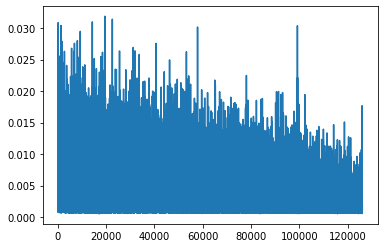

In [20]:
plt.plot(losses[20000:])

In [21]:
sequence, scaler = get_all_items_seq(tw=TRAIN_WINDOW)
sequence = [x[0] for x in sequence]
test_seq = sequence[-100]
model.eval()
predictions = []
for i in range(100):
  seq = test_seq[-TRAIN_WINDOW:].view(BATCH_SIZE, TRAIN_WINDOW, 500).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda())
    test_seq = torch.cat((test_seq,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)





100%|██████████| 1461/1461 [00:00<00:00, 17702.19it/s]


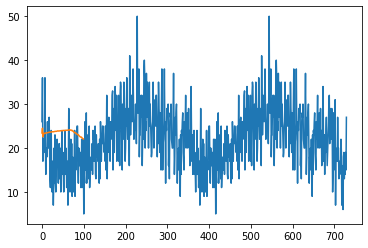

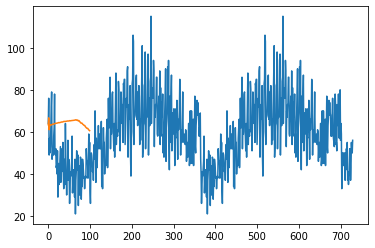

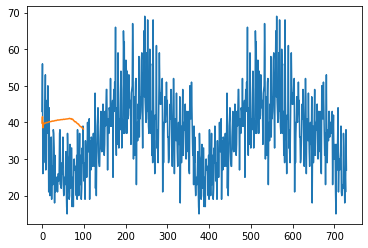

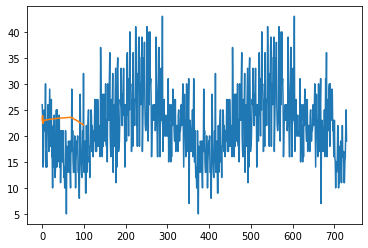

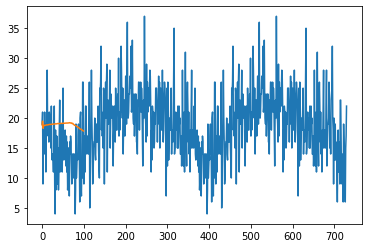

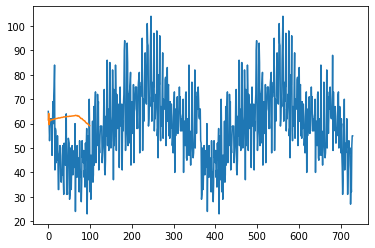

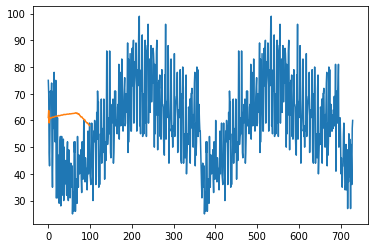

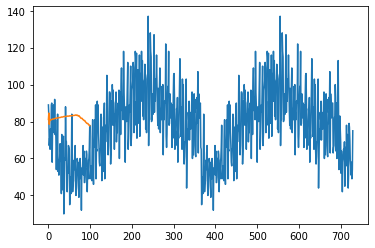

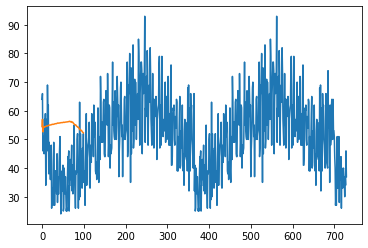

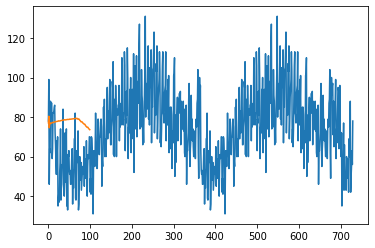

In [22]:
test_seq = torch.cat((sequence[-50], sequence[-1]), 0)
for i in range(10):
  random.randrange(0,499)
  item_1 = [x[i].item() for x in test_seq]
  item_1 = scaler.inverse_transform(np.array(item_1).reshape(-1,1)).reshape(-1)
  item_1_hat = [x[i] for x in predictions]
  plt.figure()
  plt.plot(item_1)
  plt.plot(item_1_hat)
  plt.show()

In [ ]:
sequence, scaler = get_all_items_seq(tw = TRAIN_WINDOW)
sequence = [x[0] for x in sequence]
test_seq = sequence[-1]
model.eval()
predictions = []
for i in range(100):
  seq = test_seq[-TRAIN_WINDOW:].view(BATCH_SIZE, TRAIN_WINDOW, 500).cuda()
  with torch.no_grad():
    model.hidden = (torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda(),
                    torch.zeros(NUM_LAYERS,BATCH_SIZE, model.hidden_layer_size).cuda())
    test_seq = torch.cat((test_seq,model(seq).cpu().view(1,-1)), 0)
    y_hat = scaler.inverse_transform(np.array(model(seq).detach().cpu()).reshape(-1,1)).reshape(-1)
    predictions.append(y_hat)














100%|██████████| 1726/1726 [00:00<00:00, 137688.17it/s]


In [23]:
dates = pd.Series(pd.date_range(start='1/1/2018', end='3/31/2018')).repeat(500)
stores = pd.concat([pd.Series(range(1,11)).repeat(50)] *90)
items = pd.concat([pd.Series(range(1,51))] * 900)
dates.index = range(0,45000)
stores.index = range(0,45000)
items.index = range(0,45000)
sales = pd.Series(np.vstack(predictions).reshape(-1)[:45000])
submission = pd.DataFrame({'dates':dates, 'stores':stores, 'items':items, 'sales':sales})
submission = submission.sort_values(['items', 'stores', 'dates'], ascending=[True, True, True])
submission.index = range(0, 45000)
submission.to_csv('./all_output1.csv')